In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
from torch.utils import data
from torchvision import transforms
from torch import nn
from torch.nn import functional as F


In [2]:
trans1 = transforms.Compose([transforms.ToTensor()])
explore_data = torchvision.datasets.MNIST(root="../data", train=True, transform=trans1, download=True)
explore_loader = data.DataLoader(explore_data,
                                          batch_size=len(explore_data))

In [3]:
train_mean = 0
train_std = 0

for data in explore_loader:
    train_mean = data[0].mean()
    train_std = data[0].std()
    print("train_mean: " + str(train_mean))
    print("train_std: " + str(train_std))

train_mean: tensor(0.1307)
train_std: tensor(0.3081)


In [4]:
# Load Data
def get_dataloader_workers():  #@save
    """Use 4 processes to read the data."""
    return 4

def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """Download the Fashion-MNIST dataset and then load it into memory."""
    RandAffine = transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1))
    

    trans1 = [RandAffine,
             transforms.ColorJitter(brightness=0.2, contrast=0.2),
             transforms.ToTensor(),
             transforms.Normalize(mean=(train_mean), std=(train_std))]
    
    trans2 = [transforms.ToTensor(),
             transforms.Normalize(mean=(train_mean), std=(train_std))]

    '''    
    trans1 = [transforms.ToTensor()]
    
    trans2 = [transforms.ToTensor()]
    '''
    
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans1 = transforms.Compose(trans1)
    trans2 = transforms.Compose(trans2)
    mnist_train = torchvision.datasets.MNIST(root="../data", train=True, transform=trans1, download=True)
    mnist_test = torchvision.datasets.MNIST(root="../data", train=False, transform=trans2, download=True)
    
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))



In [5]:
class Timer:  #@save
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

def evaluate_accuracy(net, data_iter):  #@save
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions

    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def accuracy(y_hat, y): #@save
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

class Accumulator:  #@save
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
class Animator:  #@save
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(10.5, 7.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
        
def evaluate_accuracy_gpu(net, data_iter, device=None):  #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 1.0],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = Timer(), len(train_iter)
    print('start')
    best_acc = 0
    counter = 0
    for epoch in range(num_epochs):
        print(epoch)
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
        
        if test_acc > best_acc:
            best_acc = test_acc
            counter = 0
        else:
            counter += 1
            if counter >= 10:
                print('Early Stop')
                break
        
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')   
    
def try_gpu(i=0):  
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def train_epoc_ch3(net, train_iter, loss, updater): #@save
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat,y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoc_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    print("train loss: " + str(train_loss))
    print("train acc: " + str(train_acc))
    print("test acc: " + str(test_acc))
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

def get_fashion_mnist_labels(labels):  #@save
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
        'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

def predict_ch3(net, test_iter, n=6): #@save
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

In [6]:
%matplotlib inline
import numpy as np
from IPython import display
import matplotlib.pyplot as plt

def use_svg_display():  #@save
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')
    
def set_figsize(figsize=(10.5, 7.5)):  #@save
    """Set the figure size for matplotlib."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
    
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):  #@save
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(10.5, 7.5), axes=None):  #@save
    """Plot data points."""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # Return True if `X` (tensor or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or
                isinstance(X, list) and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

In [7]:
# Model
'''
net = nn.Sequential(nn.Flatten(), 
                    nn.Linear(784, 256),
                    nn.Dropout(0.25),
                    nn.ReLU(),
                    nn.Linear(256, 32), 
                    nn.Dropout(0.25),
                    nn.ReLU(),
                    nn.Linear(32, 10), 
                    torch.nn.LogSoftmax(dim=1))
'''
'''

b1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), 
                   nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
                   nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2, 2), 
                   nn.Dropout(0.25))

b2 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2, 2),
            nn.Dropout(0.25))

b3 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
                   nn.MaxPool2d(2, 2), nn.Dropout(0.25))
'''

class Residual(nn.Module):  #@save
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels, use_1x1conv=False,
                 strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3,
                               padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3,
                               padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(
                Residual(input_channels, num_channels, use_1x1conv=True,
                         strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk


b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(*resnet_block(64, 64, 3, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 3))
b4 = nn.Sequential(*resnet_block(128, 256, 3))
b5 = nn.Sequential(*resnet_block(256, 512, 3))


# net = nn.Sequential(b1, b2, b3, nn.Sequential(nn.Flatten(), nn.Linear(128, 10)))

net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(512, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
net.apply(init_weights)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-

loss 0.016, train acc 0.995, test acc 0.996
33.0 examples/sec on cpu


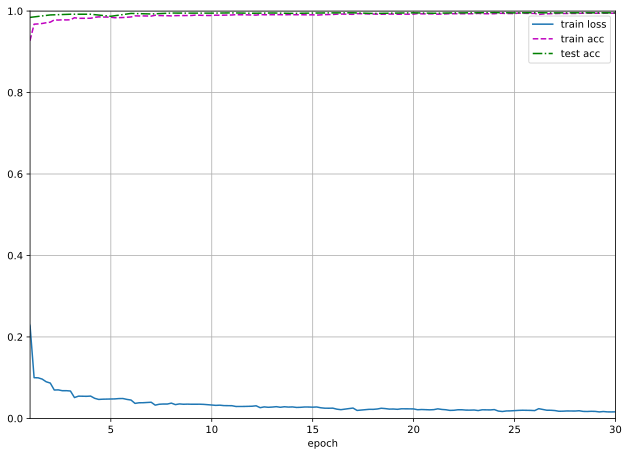

In [8]:
#batch_size, lr, num_epochs, wd = 16, 1e-4, 100, 0
#batch_size, lr, num_epochs, wd = 10, 0.001, 20, 0
batch_size, lr, num_epochs, wd = 64, 0.01, 30, 0

loss = nn.CrossEntropyLoss()

trainer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)  
                          
train_iter, test_iter = load_data_fashion_mnist(batch_size)
#train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())

# SGD 256, 0.1, 50, 0, 0
train loss: 0.20622892615000407
train acc: 0.9248666666666666
test acc: 0.8762


# Adam 256, 0.01, 50, 0, 0.2/0.5
train loss: 0.21531110235850015
train acc: 0.9199166666666667
test acc: 0.8914

# Resnet 256, 0.001, 50, 0, 0.2/0.5
loss 0.462, train acc 0.824, test acc 0.847
114.0 examples/sec on cpu
